### 16 Regression Discontinuity Design

$D_i = \mathcal{1}\{R_i>c\}$
- T= 0 when R < c, T=1 when R>c
- Two potential outcome functions before and after the threshold c switch.
- Sharp RD design
- fuzzy RD design
- EX) Alcohol minimum age - 21/18 is the switch c because probability jumps sharp after this threshold.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

In [6]:
drinking = pd.read_csv('drinking.csv')
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


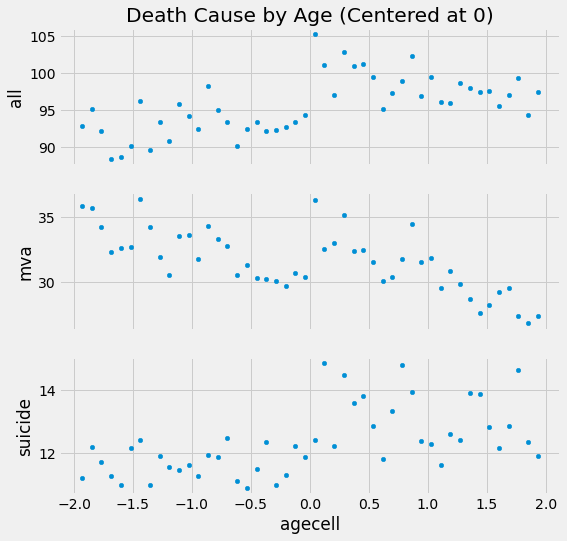

In [7]:
drinking["agecell"] -= 21
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);

### RDD Estimation
$$ \lim_{r \to c^-} E[Y_{ti}|R_i=r] = \lim_{r \to c^+} E[Y_{ti}|R_i=r] $$
<br>
\begin{split}
\begin{align}
\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=&\lim_{r \to c^+} E[Y_{1i}|R_i=r] - \lim_{r \to c^-} E[Y_{0i}|R_i=r] \\
=& E[Y_{1i}|R_i=r] - E[Y_{0i}|R_i=r] \\
=& E[Y_{1i} - Y_{0i}|R_i=r]
\end{align}
\end{split}
<br>
$ y_i = \beta_0 + \beta_1 r_i + \beta_2 \mathcal{1}\{r_i>c\} + \beta_3 \mathcal{1}\{r_i>c\} r_i $
- $\beta_0=\lim_{r \to c^-} E[Y_{ti}|R_i=r]$
- $\lim_{r \to c^+} E[Y_{ti}|R_i=r] - \lim_{r \to c^-} E[Y_{ti}|R_i=r]=\beta_2=E[ATE|R=c]$
- This is same as OLS where $\beta_0$ is intercept for r<c and $\beta_0 + \beta_2$ is the intercept for r>c

In [8]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


- The death caused by alcohol consumption increases by 7.66%

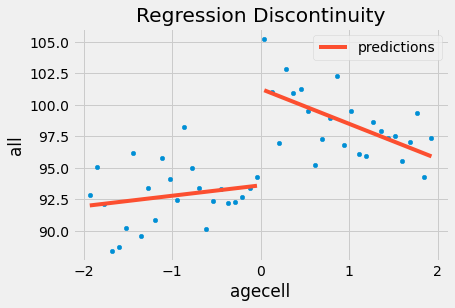

In [13]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

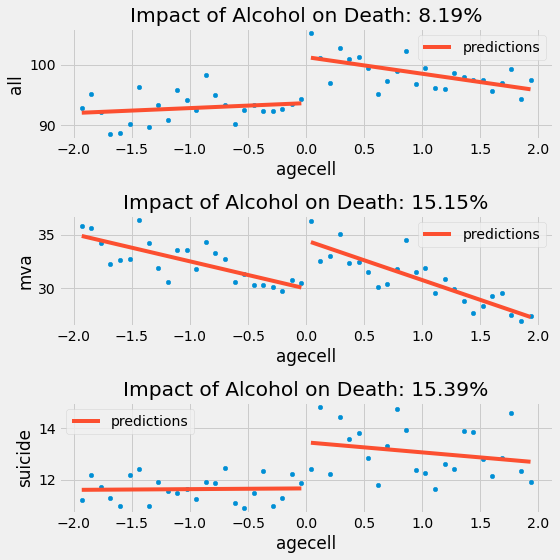

In [18]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

## Kernel weighting
- triangular kernel is a popular way of giving higher weights for points that are closer to the threshold.
- We care more for datapoints closer to the threshold to fit properly.
<br>
$ K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg) $
- h is how far we want to apply to r our kernel weighting.

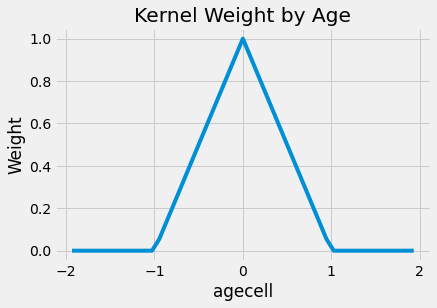

In [15]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

In [16]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


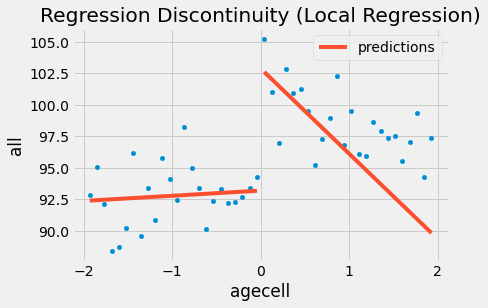

In [19]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

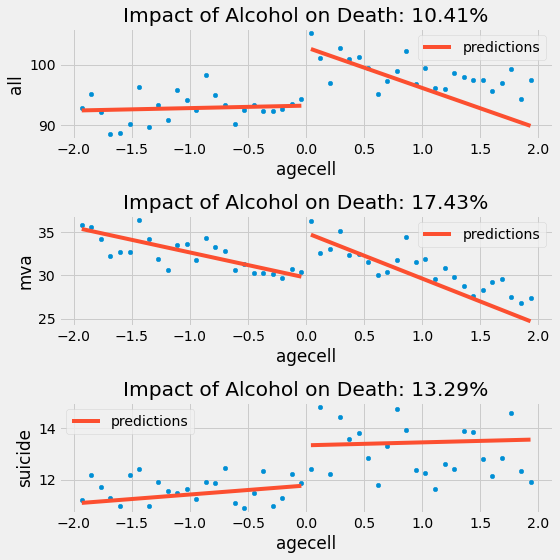

In [21]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

### Sheepskin Effect and Fuzzy RDD
- ex) education is just a signal to a good employee.
- ex) near to passing score from the left and right will have similar human capital, but sifferent signaling credentials.

In [26]:
sheepskin = pd.read_csv("sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]

print(sheepskin['receivehsd'].min())
print(sheepskin['receivehsd'].max())
print(sheepskin.head())

0.23673469
0.9673913
   avgearnings  minscore  receivehsd   n
0    11845.086     -30.0    0.416667  12
1     9205.679     -29.0    0.387097  31
2     8407.745     -28.0    0.318182  44
3    11114.087     -27.0    0.377778  45
4    10814.624     -26.0    0.306667  75


- We use fuzzy RDD because of some students failed will manage to get diploma anyway.
- The probability is not 0 to 1. It is from 23% to 96%

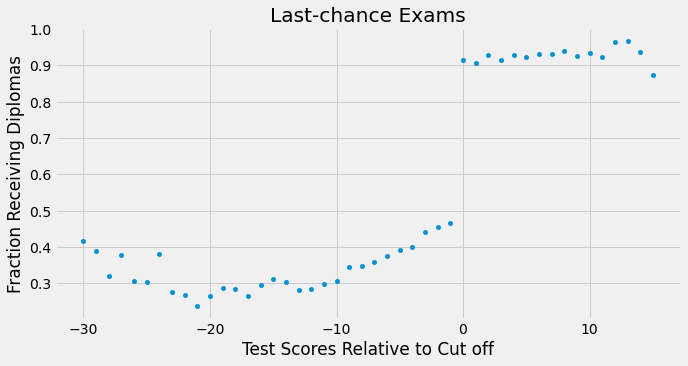

In [27]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

$ \dfrac{\lim_{r \to c^+} E[Y_i|R_i=r] - \lim_{r \to c^-} E[Y_i|R_i=r]}{\lim_{r \to c^+} E[T_i|R_i=r] - \lim_{r \to c^-} E[T_i|R_i=r]} = E[Y_{1i} - Y_{0i} | T_{1i} > T_{0i}, R_i=c]$ 

### The McCrary Test


- cheaters 1. found a way to increase the score by system. 2. Lowering income to get less tax
- Density of the running variable

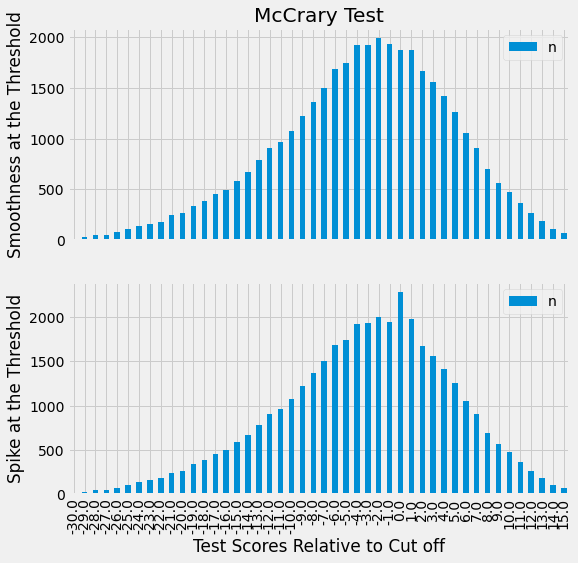

In [29]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

In [30]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


effect of a diploma is -97, but p is bad.

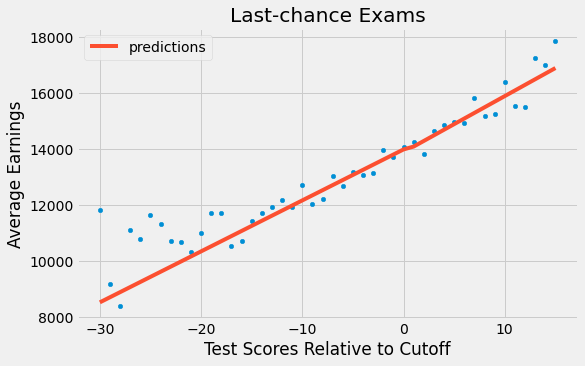

In [32]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");
#No skin effect. Very continuous line at the threshold.

- The result is biased towards zero. 
- Wald estimator

In [33]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

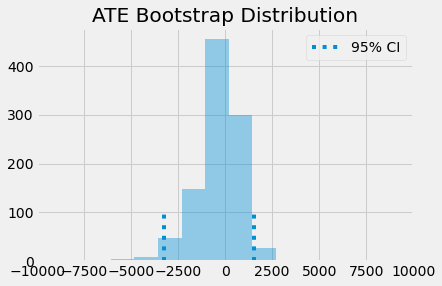

In [34]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();